In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.615778,0.960922,00:01
1,0.850800,0.667529,00:00
2,0.647658,0.657161,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [9]:
path=Config.data_path()/'ml-100k'

In [11]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
len(ratings)

100000

In [14]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [15]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [16]:
data.show_batch()

userId,title,target
323,"Shawshank Redemption, The (1994)",5.0
348,Leaving Las Vegas (1995),3.0
712,Free Willy (1993),4.0
684,Nine Months (1995),2.0
145,Austin Powers: International Man of Mystery (1997),4.0


In [17]:
y_range = [0,5.5]

In [18]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


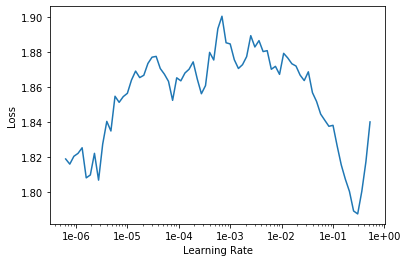

In [19]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [20]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.956409,0.947708,00:04
1,0.833848,0.879708,00:04
2,0.770396,0.832348,00:04
3,0.660932,0.812483,00:04
4,0.569283,0.812909,00:04


In [21]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [22]:
learn.load('dotprod');

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [24]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [25]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [26]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [27]:
item0 = lambda o:o[0]

In [28]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3843),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2827),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2559), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2553), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2432), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2349), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2330), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2322), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2200), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2174), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2153), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2049), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2042), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2034), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.2033)

In [29]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6015), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5850), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5625), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5526), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5346), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5257), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5162), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4976), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4953), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4856), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4600), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4599), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4590), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4578), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4514), 'Godfather, The (1972)', 4.283292978208232)]

### Movie weights

In [30]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [31]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [32]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0263), 'Wrong Trousers, The (1993)'),
 (tensor(1.0116), 'Lawrence of Arabia (1962)'),
 (tensor(1.0112), 'Casablanca (1942)'),
 (tensor(0.9947),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9898), '12 Angry Men (1957)'),
 (tensor(0.9690), 'Godfather, The (1972)'),
 (tensor(0.9621), 'When We Were Kings (1996)'),
 (tensor(0.9516), 'Ran (1985)'),
 (tensor(0.9458), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.9438), 'Chinatown (1974)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3359), 'Home Alone 3 (1997)'),
 (tensor(-1.2534), 'Jungle2Jungle (1997)'),
 (tensor(-1.2432), "McHale's Navy (1997)"),
 (tensor(-1.1234), 'Leave It to Beaver (1997)'),
 (tensor(-1.1063), 'Grease 2 (1982)'),
 (tensor(-1.1022), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0857), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0848), 'Batman & Robin (1997)'),
 (tensor(-1.0706), 'Bio-Dome (1996)'),
 (tensor(-1.0438), 'Mortal Kombat: Annihilation (1997)')]

In [35]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [36]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1512), 'Braveheart (1995)'),
 (tensor(1.1079), 'Titanic (1997)'),
 (tensor(1.0317), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.8891), "It's a Wonderful Life (1946)"),
 (tensor(0.8615), "Mr. Holland's Opus (1995)"),
 (tensor(0.8614), 'Forrest Gump (1994)'),
 (tensor(0.8530), 'Pretty Woman (1990)'),
 (tensor(0.8369), 'American President, The (1995)'),
 (tensor(0.8314), 'Hunt for Red October, The (1990)'),
 (tensor(0.8272), 'Sleepless in Seattle (1993)')]

In [37]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8781), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8530), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.8180), 'Cable Guy, The (1996)'),
 (tensor(-0.8148), 'Keys to Tulsa (1997)'),
 (tensor(-0.8055), 'Clockwork Orange, A (1971)'),
 (tensor(-0.8038), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.8036), 'Brazil (1985)'),
 (tensor(-0.7951), 'Trainspotting (1996)'),
 (tensor(-0.7737), 'Heavenly Creatures (1994)'),
 (tensor(-0.7571), 'Lost Highway (1997)')]

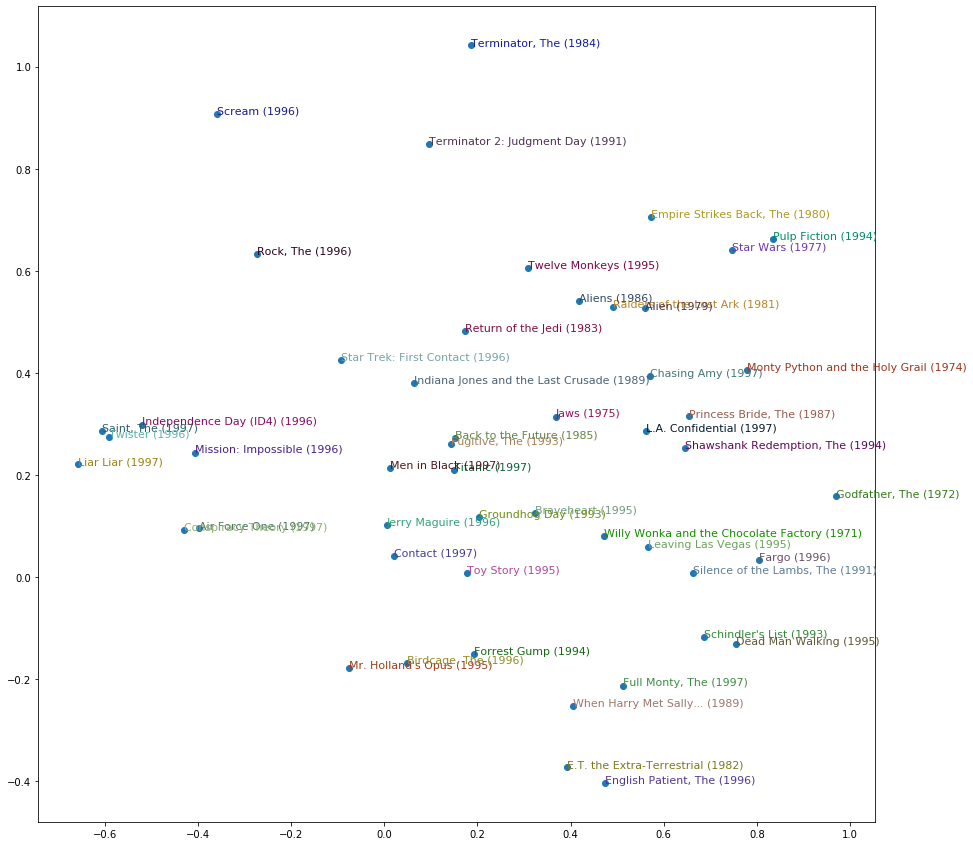

In [38]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()